<a href="https://colab.research.google.com/github/mariemtouihri/GRAM-Metric/blob/main/single_metrics_in_one_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import json
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# All correlations

In [ ]:
def upload_correlations(correlation, name):

  corr_values = {}
  corr_values['pearson'] = []
  corr_values['spearman'] = []
  corr_values['kendall'] = []


  for j in range(8):

    # Define the path to your JSON file
    file_path = f'/content/drive/MyDrive/Colab_Notebooks/{name}/{name}_correlations_matrices_G{j+1}.json'

    # Open and read the JSON file
    with open(file_path, 'r') as json_file:
        corr_dict = json.load(json_file)

        if j== 0:
          corr_values['pearson'].extend(corr_dict["pearson_values"])
          corr_values['spearman'].extend(corr_dict["spearman_values"])
          corr_values['kendall'].extend(corr_dict["ktau_values"])
        else:
          corr_values['pearson'] = np.vstack((corr_values['pearson'], corr_dict["pearson_values"]))
          corr_values['spearman'] = np.vstack((corr_values['spearman'], corr_dict["spearman_values"]))
          corr_values['kendall'] = np.vstack((corr_values['kendall'], corr_dict["ktau_values"]))


  # Ready to be plotted (results from all matrices horray!)
  correlation_values = np.mean(corr_values[correlation], axis=0)

  return correlation_values


In [ ]:
def compute_correlations():
  centralities = {}
  types = ["pearson", "spearman", "kendall"]
  for corr_type in types:
    centralities[corr_type] = {}
    centralities[corr_type]['Betweenness'] = list(upload_correlations(corr_type, "betweenness"))
    centralities[corr_type]['Closeness'] = list(upload_correlations(corr_type, "closeness"))
    centralities[corr_type]['Weighted Degree'] = list(upload_correlations(corr_type, "w_degree"))
    centralities[corr_type]['Eigenvector'] = list(upload_correlations(corr_type, "eigen"))
    centralities[corr_type]['PageRank'] = list(upload_correlations(corr_type, "pagerank"))
    centralities[corr_type]['Katz'] = list(upload_correlations(corr_type, "katz"))
    centralities[corr_type]['Hub-Authority'] = list(upload_correlations(corr_type, "hub_auth"))
    centralities[corr_type]['Harmony'] = list(upload_correlations(corr_type, "harmony"))
    centralities[corr_type]['Average Neighbor'] = list(upload_correlations(corr_type, "avg_n_d"))
    centralities[corr_type]['Diversity Index'] = list(upload_correlations(corr_type, "diversity"))
  return centralities

In [ ]:
def compute_correlations():
    centralities = {}
    centralities['Betweenness'] = list(upload_correlations("betweenness"))
    centralities['Closeness'] = list(upload_correlations("closeness"))
    centralities['Weighted Degree'] = list(upload_correlations("w_degree"))
    centralities['Eigenvector'] = list(upload_correlations("eigen"))
    centralities['PageRank'] = list(upload_correlations("pagerank"))
    centralities['Katz'] = list(upload_correlations("katz"))
    centralities['Hub-Authority'] = list(upload_correlations("hub_auth"))
    centralities['Harmony'] = list(upload_correlations("harmony"))
    centralities['Average Neighbor'] = list(upload_correlations("avg_n_d"))
    centralities['Diversity Index'] = list(upload_correlations("diversity"))
    return centralities


def plot_spearman_correlation(centralities):
    metrics = list(centralities.keys())

    plt.figure(figsize=(10, 6))
    x_interp = np.linspace(0, 100, num=100)
    y_interp = np.linspace(1, 0, num=100)

    for metric in metrics:
        # Get the provided y-values for the current metric
        y_values = centralities[metric]

        # Interpolate and scale the y-values
        f = CubicSpline(np.linspace(0, 100, num=len(y_values)), y_values)
        interpolated_values = f(x_interp)
        scaled_values = interpolated_values * y_interp + (1 - y_interp[0])
        max_value = max(scaled_values)
        scaled_values -= (max_value - 1)  # Adjust y-axis to start at 1.0 at 0% modification
        # Adjust y-values at the end to approximate 0 at 100% modification
        scaled_values[-10:] *= np.linspace(1, 0, 10)

        # Plot the result
        plt.plot(x_interp, scaled_values, label=f'{metric}', linewidth=2)



    # Add the perfect line from 1 to 0
    plt.plot(x_interp, y_interp, label='Reference Line', color='black', linestyle='--', linewidth=1)

    plt.xlabel('Modification Percentage')
    plt.ylabel('Kendall\'s Tau Correlation')
    plt.title('Kendall\'s Tau Correlation for Single Centrality Metrics')
    plt.legend()
    plt.ylim(0, 1.0)  # Set y-axis limit to 0 to 1.0
    plt.grid(True)
    plt.show()



# Test

## Weighted degree surface loss

In [ ]:
############

#############

# Define the PyTorch model
class SurfacePredictionModel(nn.Module):
    def __init__(self):
        super(SurfacePredictionModel, self).__init__()
        self.linear = nn.Linear(10, 1, bias=False)  # B matrix as a linear layer without bias
        self.linear.weight.requires_grad = True

    def forward(self, A):
        # The forward pass will multiply A with the learned B matrix
        B = self.linear.weight
        return torch.matmul(A, B.t())

# Custom loss function


def fit_polynomial(x, y, degree):
    # Create matrix for polynomial fit
    powers = torch.arange(degree + 1).unsqueeze(0).repeat(len(x), 1)
    X = torch.pow(x.unsqueeze(1), powers)
    # Solve the least squares problem X * coeffs = y to find coeffs
    result = torch.linalg.lstsq(X, y.unsqueeze(1))
    coeffs = result.solution[:degree + 1, 0]  # Get the coefficients up to the required degree
    return coeffs

def approximate_integral(poly_coeffs, x_min, x_max, num_points=1000):
    x = torch.linspace(x_min, x_max, num_points)
    powers = torch.arange(len(poly_coeffs)).flip(0).unsqueeze(0).repeat(len(x), 1)
    poly_values = torch.pow(x.unsqueeze(1), powers) * poly_coeffs.flip(0).unsqueeze(0)
    integral = poly_values.sum(dim=1).mean() * (x_max - x_min)
    return integral

def custom_loss(A_tensors, target_area1,target_area2, model):
    total_loss1 = 0.0
    total_loss2 = 0.0
    degree = 9

    for A in A_tensors:
        predicted_C = model(A)
        predicted_C1 = predicted_C[:5].view(-1)  # First 5 elements, reshaped for fitting
        predicted_C2 = predicted_C[-6:].view(-1)  # Last 6 elements, reshaped for fitting

        # Fit and integrate for the first part
        coefficients1 = fit_polynomial(noise_tensor1, predicted_C1, degree)
        integral_value1 = approximate_integral(coefficients1, noise_tensor1.min(), noise_tensor1.max())
        integral_value_tensor1 = integral_value1.requires_grad_(True)
        loss1 = nn.functional.l1_loss(integral_value_tensor1, target_area1)
        total_loss1 += loss1

        # Fit and integrate for the second part
        coefficients2 = fit_polynomial(noise_tensor2, predicted_C2, degree)
        integral_value2 = approximate_integral(coefficients2, noise_tensor2.min(), noise_tensor2.max())
        integral_value_tensor2 = integral_value2.requires_grad_(True)
        loss2 = nn.functional.l1_loss(integral_value_tensor2, target_area2)
        total_loss2 += loss2

    avg_loss1 = total_loss1 / len(A_tensors)
    avg_loss2 = total_loss2 / len(A_tensors)
    return (avg_loss1 + avg_loss2) / 2





target_area1 = torch.tensor(0.28, dtype=torch.float32)
target_area2 = torch.tensor(0.125, dtype=torch.float32)
model = SurfacePredictionModel()
optimizer = Adam(list(model.parameters()),lr=0.01)


In [ ]:
import torch

def fit_polynomial(x, y, degree):
    # Create Vandermonde matrix for polynomial fit
    powers = torch.arange(degree + 1).unsqueeze(0).repeat(len(x), 1)
    X = torch.pow(x.unsqueeze(1), powers)
    # Solve the least squares problem X * coeffs = y to find coeffs
    result = torch.linalg.lstsq(X, y.unsqueeze(1))
    coeffs = result.solution[:degree + 1, 0]  # Get the coefficients up to the required degree
    return coeffs

def approximate_integral(poly_coeffs, x_min, x_max, num_points=1000):
    x = torch.linspace(x_min, x_max, num_points)
    powers = torch.arange(len(poly_coeffs)).flip(0).unsqueeze(0).repeat(len(x), 1)
    poly_values = torch.pow(x.unsqueeze(1), powers) * poly_coeffs.flip(0).unsqueeze(0)
    integral = poly_values.sum(dim=1).mean() * (x_max - x_min)
    return integral

def calculate_surface(M, degree):
    # Fit the polynomial to the vector M
    x = torch.arange(len(M), dtype=torch.float32)
    y = torch.tensor(M, dtype=torch.float32)
    poly_coeffs = fit_polynomial(x, y, degree)

    # Calculate the integral of the fitted polynomial
    x_min, x_max = x.min(), x.max()
    surface_area = approximate_integral(poly_coeffs, x_min, x_max)

    return surface_area




In [ ]:
import torch
import torch.nn.functional as F

def fit_polynomial(x, y, degree):
    powers = torch.arange(degree + 1).unsqueeze(0).repeat(len(x), 1)
    X = torch.pow(x.unsqueeze(1), powers)
    result = torch.linalg.lstsq(X, y.unsqueeze(1))
    coeffs = result.solution[:degree + 1, 0]
    return coeffs

def approximate_integral(poly_coeffs, x_min, x_max, num_points=1000):
    x = torch.linspace(x_min, x_max, num_points)
    powers = torch.arange(len(poly_coeffs)).flip(0).unsqueeze(0).repeat(len(x), 1)
    poly_values = torch.pow(x.unsqueeze(1), powers) * poly_coeffs.flip(0).unsqueeze(0)
    integral = poly_values.sum(dim=1).mean() * (x_max - x_min)
    return integral

def calculate_loss(V, target_area1, target_area2, degree=9):
    total_loss1 = 0.0
    total_loss2 = 0.0

    V1 = V[:5]
    V2 = V[-6:]

    # Fit and integrate for the first part
    x1 = torch.arange(len(V1), dtype=torch.float32)
    coeffs1 = fit_polynomial(x1, V1, degree)
    integral1 = approximate_integral(coeffs1, x1.min(), x1.max())
    loss1 = F.l1_loss(integral1, target_area1)
    total_loss1 += loss1

    # Fit and integrate for the second part
    x2 = torch.arange(len(V2), dtype=torch.float32)
    coeffs2 = fit_polynomial(x2, V2, degree)
    integral2 = approximate_integral(coeffs2, x2.min(), x2.max())
    loss2 = F.l1_loss(integral2, target_area2)
    total_loss2 += loss2

    avg_loss = (total_loss1 + total_loss2) / 2
    return avg_loss


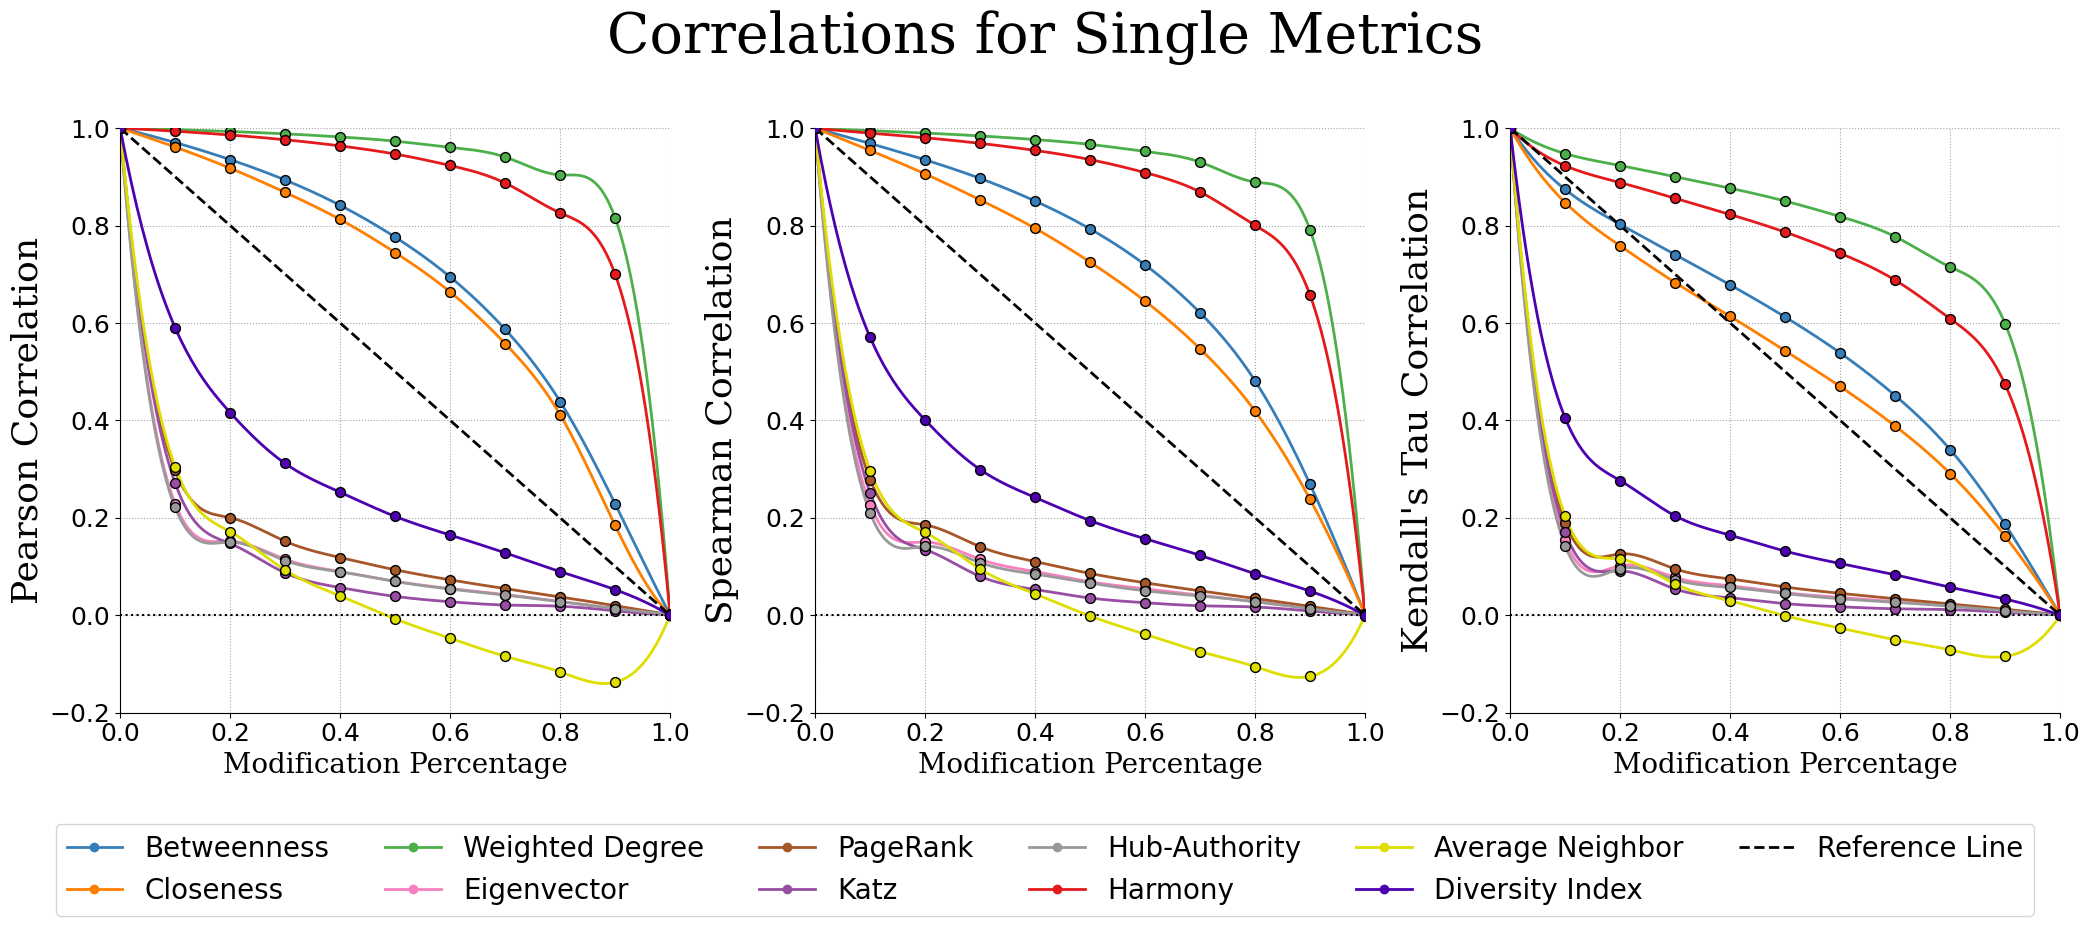

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_correlation(correlation, centralities, ax):
    metrics = list(centralities[correlation].keys())
    x_values = np.linspace(0, 1, num=len(centralities[correlation][metrics[0]]))
    y_interp = np.linspace(1, 0, num=100)  # Reference line from 1 to 0

    # Colorblind-friendly colors
    colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628',
              '#984ea3', '#999999', '#e41a1c', '#dede00', '#4d01b1']

    lines = []
    labels = []

    for metric, color in zip(metrics, colors):
        y_values = centralities[correlation][metric]

        # Use spline interpolation for smoother lines
        spline = make_interp_spline(x_values, y_values)
        x_smooth = np.linspace(0, 1, 200)
        y_smooth = spline(x_smooth)

        # Plot the smoothed line
        ax.plot(x_smooth, y_smooth, linewidth=2, color=color)

        # Plot the original data points
        ax.scatter(x_values, y_values, color=color, edgecolor='black', s=50, zorder=3)

        # Add a line with a single dot for the legend
        legend_line, = ax.plot([], [], marker='o', color=color, linewidth=2, label=f'{metric}')

        lines.append(legend_line)
        labels.append(f'{metric}')

    # Add the reference line from 1 to 0
    ref_line, = ax.plot(np.linspace(0, 1, num=100), y_interp, label='Reference Line', color='black', linestyle='--', linewidth=2)
    lines.append(ref_line)
    labels.append('Reference Line')

    # Add horizontal dotted line at y=0
    ax.axhline(y=0, color='black', linestyle=':', linewidth=1.5)

    ax.set_xlabel('Modification Percentage', fontsize=20, fontname='serif')

    if correlation == "pearson":
        ax.set_ylabel("Pearson Correlation", fontsize=26, fontname='serif')
    elif correlation == "spearman":
        ax.set_ylabel("Spearman Correlation", fontsize=26, fontname='serif')
    elif correlation == "kendall":
        ax.set_ylabel("Kendall's Tau Correlation", fontsize=26, fontname='serif')

    ax.set_ylim(-0.2, 1.0)  # Adjusted y-axis limits
    ax.set_xlim(0, 1)
    ax.grid(True, linestyle=':', color='gray', alpha=0.7)
    ax.set_facecolor('white')

    # Adjust spines to meet at specific points
    ax.spines['left'].set_position(('data', 0))  # x-axis intersects at y=0
    ax.spines['bottom'].set_position(('data', -0.2))  # y-axis intersects at x=-0.2
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', which='major', labelsize=18)

    return lines, labels

correlations = compute_correlations()

fig, axes = plt.subplots(1, 3, figsize=(21, 8))

lines1, labels1 = plot_correlation("pearson", correlations, axes[0])
lines2, labels2 = plot_correlation("spearman", correlations, axes[1])
lines3, labels3 = plot_correlation("kendall", correlations, axes[2])

all_lines = lines1[:] + lines2[:] + lines3[:]
all_labels = labels1[:] + labels2[:] + labels3[:]

fig.legend(all_lines[:len(lines1)], all_labels[:len(labels1)], loc='lower center', bbox_to_anchor=(0.5, -0.17), ncol=6, fontsize=20)

fig.suptitle("Correlations for Single Metrics", fontsize=40, fontname='serif')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
